In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Visualisation for Yields:
### Density of Crop data by municipality 

In [31]:
df_yields = pd.read_csv("./data/Yields.csv")
df_weather = pd.read_csv("./data/Weather Reanalysis.csv")

n_crops = df_yields["Crop"].nunique(dropna=True)
n_munis = df_yields["Municipality"].nunique(dropna=True)
print(f"- number of different crops: {n_crops}") # 53 crops expected
print(f"- number of different municipalities in df_yields: {n_munis}") # 99 municipalities expected

n_munis = df_weather["Municipality"].nunique(dropna=True)
print(f"- number of different municipalities in df_weather: {n_munis}") # 84 municipalities expected

# filter df_yields to contain the same municipalitys as in df_weather
munis_weather = df_weather["Municipality"].unique()
df_yields = df_yields[df_yields["Municipality"].isin(munis_weather)]
n_munis = df_yields["Municipality"].nunique(dropna=True)
print(f"- number of different municipalities after filtering: {n_munis}")


- number of different crops: 53
- number of different municipalities in df_yields: 99
- number of different municipalities in df_weather: 84
- number of different municipalities after filtering: 84


In [32]:
def crop_sum_density_df(df_yields: pd.DataFrame) -> pd.DataFrame:
    df = df_yields.copy()
    df["crop_sum"] = df.groupby(["Municipality", "Crop"])["Year"].transform("size")
    return (df[["Municipality", "Crop", "crop_sum"]]
            .drop_duplicates()
            .reset_index(drop=True))

# Plot heatmap Municipality vs Crop using crop_sum as “temperature”
def plot_density_heatmap(density_df: pd.DataFrame, title="Density (#rows) by Municipality × Crop"):
    pivot = density_df.pivot(index="Crop", columns="Municipality", values="crop_sum").fillna(0)

    fig_w = max(10, pivot.shape[1] * 0.35)
    fig_h = max(6,  pivot.shape[0] * 0.35)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    im = ax.imshow(pivot.values, aspect="auto", cmap="viridis")
    ax.set_xticks(np.arange(pivot.shape[1]))
    ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_xticklabels(pivot.columns, rotation=90)
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel("Municipality")
    ax.set_ylabel("Crop")
    ax.set_title(title)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("crop_sum (#rows per Municipality×Crop)")

    plt.tight_layout()
    plt.show()

def drop_low_municipalities(density_df: pd.DataFrame, percent: float) -> pd.DataFrame:
    """
    Keep municipalities whose BEST crop (max crop_sum over crops) is not in the bottom `percent`.
    """
    muni_peaks = density_df.groupby("Municipality")["crop_sum"].max()

    threshold = muni_peaks.quantile(percent / 100.0)

    keep = muni_peaks[muni_peaks > threshold].index
    return density_df[density_df["Municipality"].isin(keep)].copy()


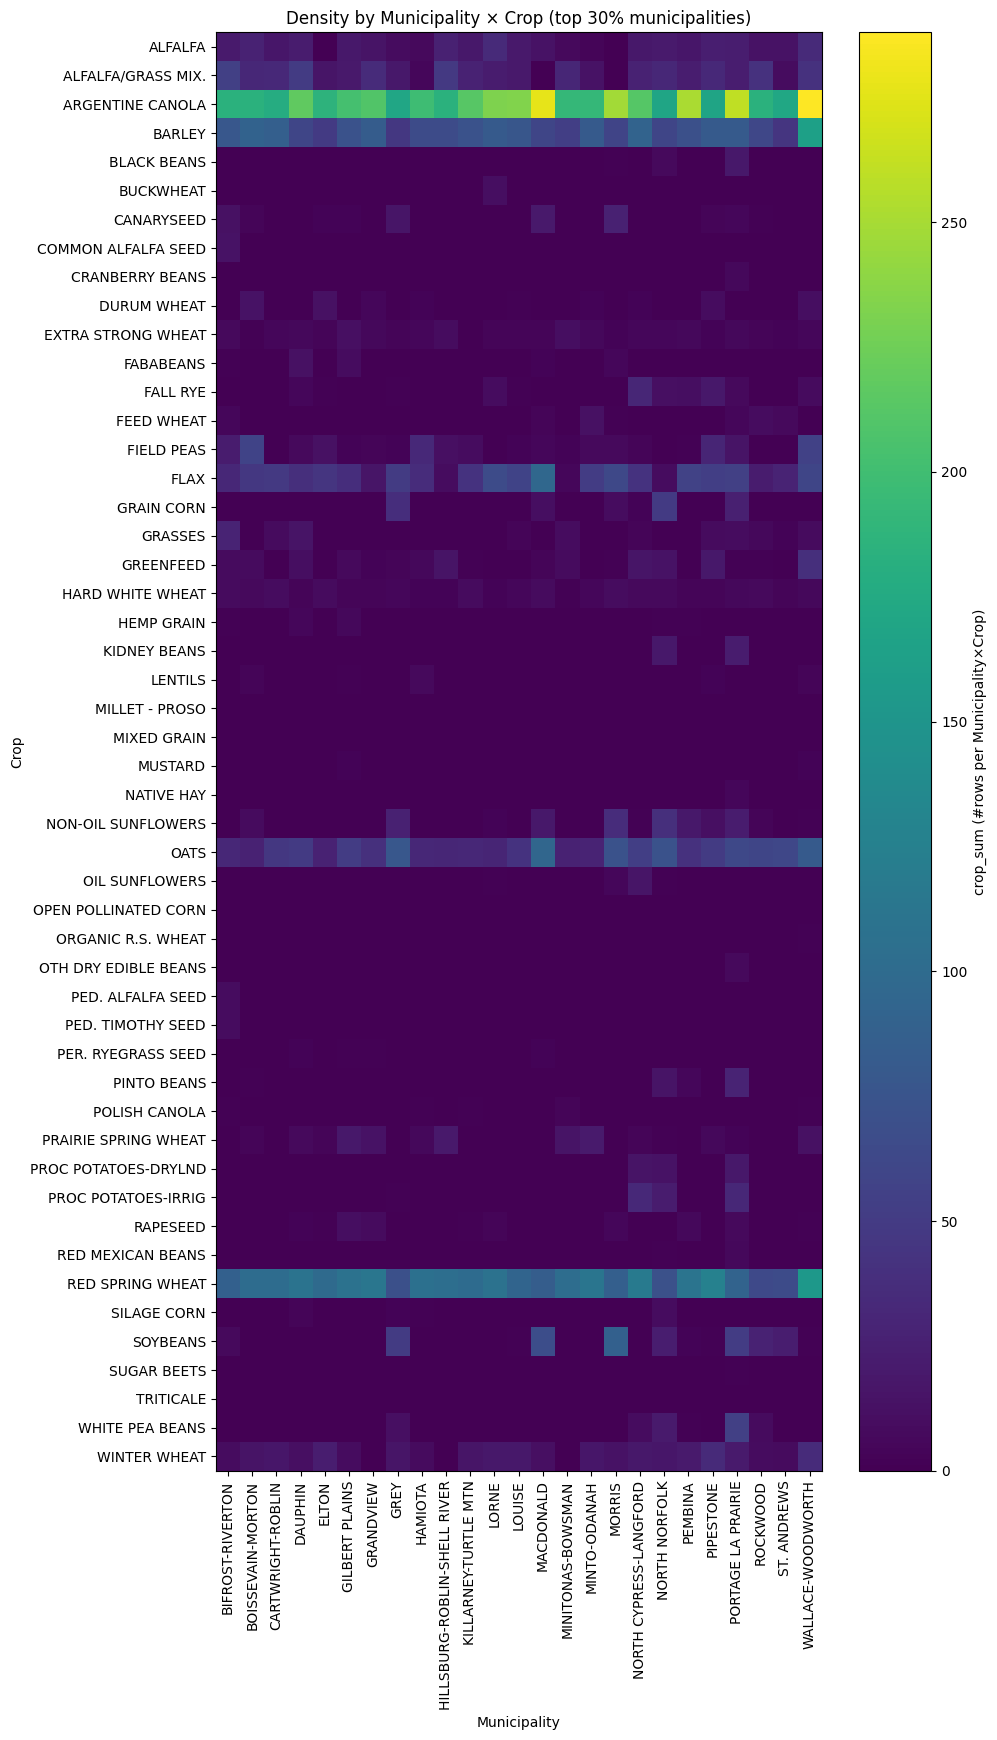

In [33]:
density_df = crop_sum_density_df(df_yields)

density_df_top = drop_low_municipalities(density_df, percent=70)

plot_density_heatmap(density_df_top, title="Density by Municipality × Crop (top 30% municipalities)")

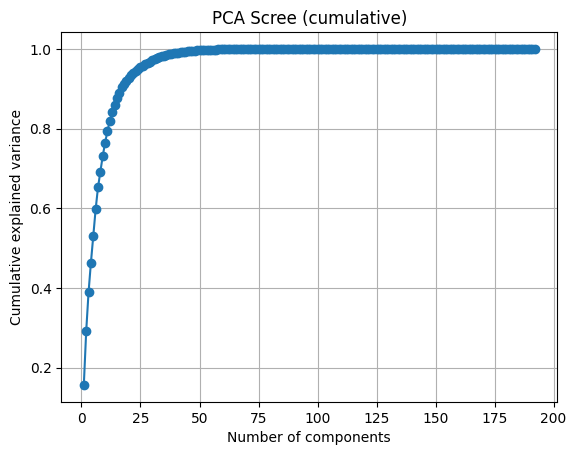

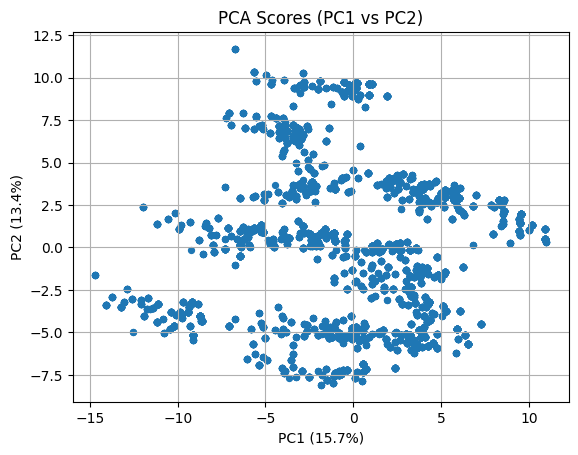

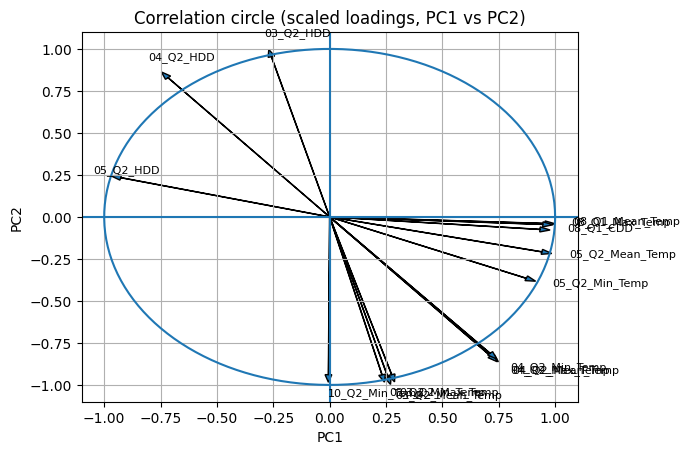

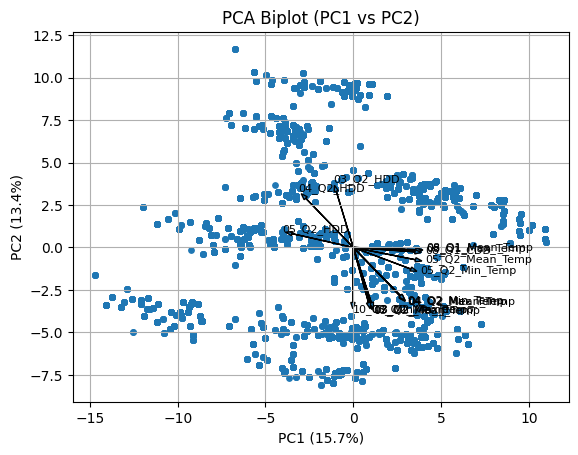

In [34]:
# =========================
# PCA / ACP (VISUALISATION)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- CONFIG ----
TAG = "allcrops"          # must match what you saved
IN_DIR = "./prepared"

expl = pd.read_csv(f"{IN_DIR}/pca_explained_{TAG}.csv")
loadings = pd.read_csv(f"{IN_DIR}/pca_loadings_{TAG}.csv", index_col=0)
scores = pd.read_csv(f"{IN_DIR}/pca_scores_{TAG}.csv")

# ---- 1) Scree plot (cumulative explained variance) ----
plt.figure()
plt.plot(range(1, len(expl)+1), expl["explained_variance_ratio_cum"], marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(True)
plt.title("PCA Scree (cumulative)")
plt.show()

# ---- Helper: get PC columns ----
pc_cols = [c for c in scores.columns if c.startswith("PC")]
# pick first 2
pcx, pcy = "PC1", "PC2"
if pcx not in scores.columns or pcy not in scores.columns:
    raise ValueError("PC1/PC2 not found in scores file. Check TAG/path.")

# ---- 2) PC scatter (observations) ----
plt.figure()
plt.scatter(scores[pcx], scores[pcy], s=18)
plt.xlabel(f"{pcx} ({expl.loc[0,'explained_variance_ratio']*100:.1f}%)")
plt.ylabel(f"{pcy} ({expl.loc[1,'explained_variance_ratio']*100:.1f}%)")
plt.grid(True)
plt.title("PCA Scores (PC1 vs PC2)")
plt.show()

# ---- 3) Correlation circle (approx) ----
# If X was standardized, a common approximation for correlation circle coordinates is:
# corr(var, PCk) ≈ loading(var, PCk) * sqrt(eigenvalue_k)
# We don't have eigenvalues saved, but we can approximate using explained variance ratio times total variance.
# A robust alternative: just plot loadings and scale to fit inside [-1,1].

# --- Reduce clutter: show only top variables for PC1/PC2 ---
TOP_N = 15  # try 10, 15, 20

pcx, pcy = "PC1", "PC2"

L = loadings[[pcx, pcy]].copy()

# Importance in the PC1-PC2 plane (bigger = more influential on the plot)
importance = (L[pcx]**2 + L[pcy]**2)

top_vars = importance.sort_values(ascending=False).head(TOP_N).index
L = L.loc[top_vars]


# scale arrows so they fit nicely (visual scaling, not changing meaning)
max_abs = np.abs(L.values).max()
scale = 1.0 / max_abs if max_abs > 0 else 1.0
L_plot = L * scale

plt.figure()
# unit circle
theta = np.linspace(0, 2*np.pi, 300)
plt.plot(np.cos(theta), np.sin(theta))
plt.axhline(0)
plt.axvline(0)

for var in L_plot.index:
    x, y = L_plot.loc[var, pcx], L_plot.loc[var, pcy]
    plt.arrow(0, 0, x, y, head_width=0.03, length_includes_head=True)
    plt.text(x*1.08, y*1.08, var, fontsize=8)

plt.xlabel(pcx)
plt.ylabel(pcy)
plt.title("Correlation circle (scaled loadings, PC1 vs PC2)")
plt.grid(True)
plt.show()

# ---- 4) Biplot (scores + variable directions) ----
# We'll overlay arrows from loadings (scaled) on the score plot.


plt.figure()
plt.scatter(scores[pcx], scores[pcy], s=15)

# scale arrows to match score spread
sx = scores[pcx].std()
sy = scores[pcy].std()
arrow_scale = 0.8  # tweak if too big/small

for var in L_plot.index:
    x, y = L_plot.loc[var, pcx], L_plot.loc[var, pcy]
    plt.arrow(0, 0, x*sx*arrow_scale, y*sy*arrow_scale, head_width=0.05*sx, length_includes_head=True)
    plt.text(x*sx*arrow_scale*1.05, y*sy*arrow_scale*1.05, var, fontsize=8)

plt.xlabel(f"{pcx} ({expl.loc[0,'explained_variance_ratio']*100:.1f}%)")
plt.ylabel(f"{pcy} ({expl.loc[1,'explained_variance_ratio']*100:.1f}%)")
plt.grid(True)
plt.title("PCA Biplot (PC1 vs PC2)")
plt.show()

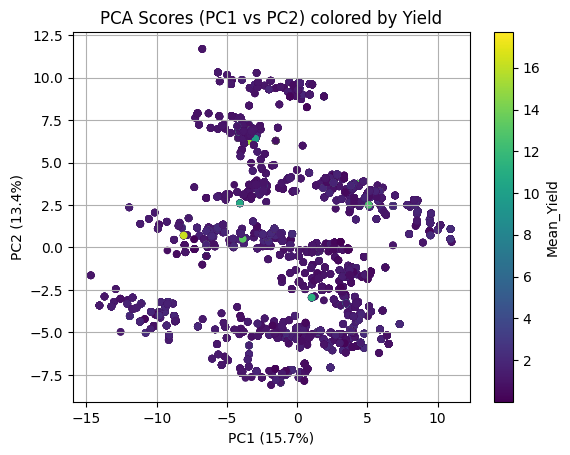

In [35]:

pcx, pcy = "PC1", "PC2"
yield_col = "Mean_Yield"   # change if your column name differs

# Keep only rows where yield exists
plot_df = scores.dropna(subset=[pcx, pcy, yield_col]).copy()

plt.figure()
sc = plt.scatter(plot_df[pcx], plot_df[pcy], s=20, c=plot_df[yield_col])
plt.xlabel(f"{pcx} ({expl.loc[0,'explained_variance_ratio']*100:.1f}%)")
plt.ylabel(f"{pcy} ({expl.loc[1,'explained_variance_ratio']*100:.1f}%)")
plt.title("PCA Scores (PC1 vs PC2) colored by Yield")
plt.grid(True)
cbar = plt.colorbar(sc)
cbar.set_label(yield_col)
plt.show()

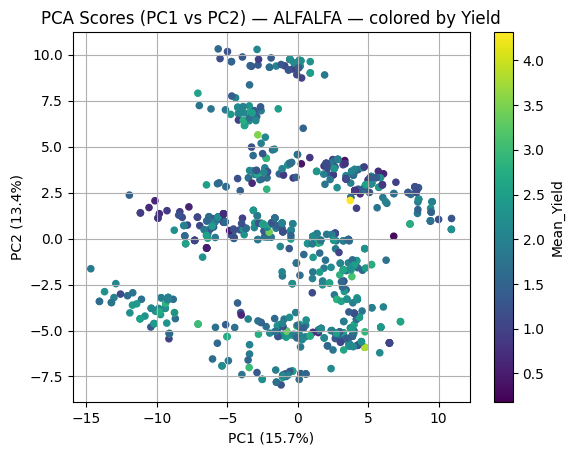

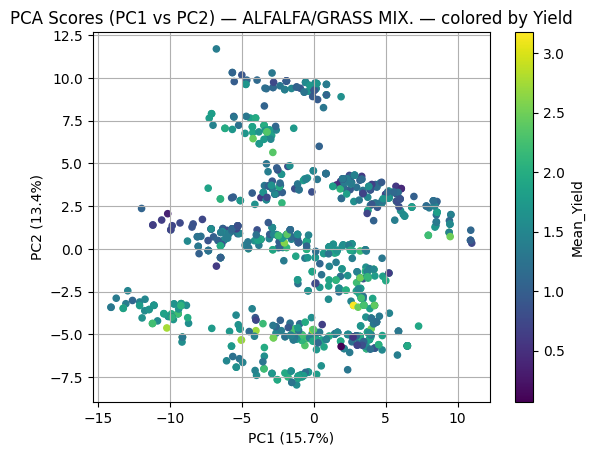

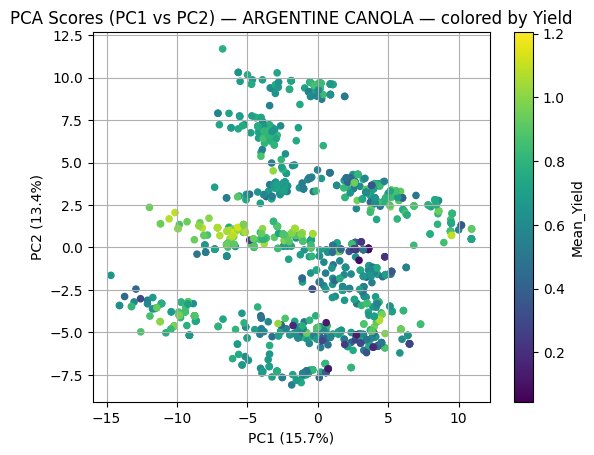

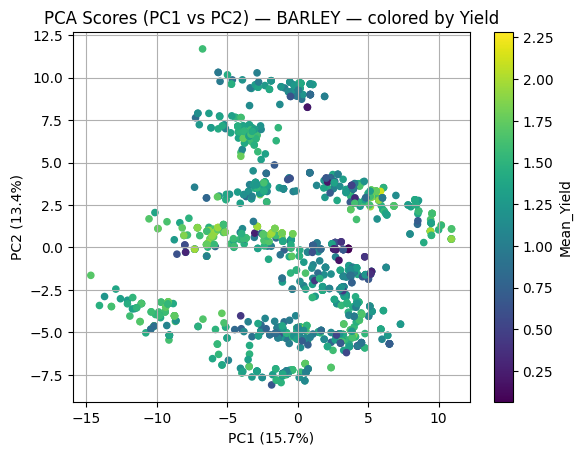

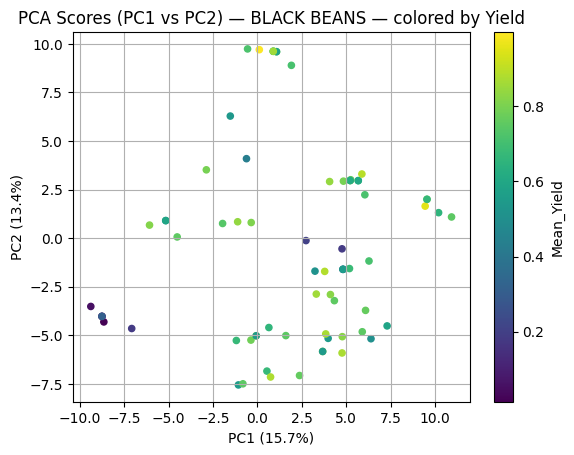

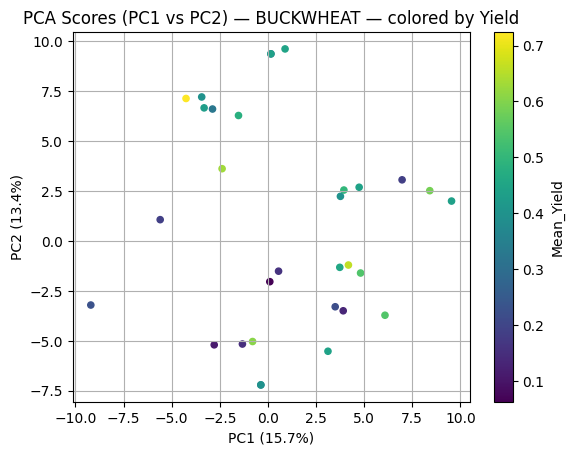

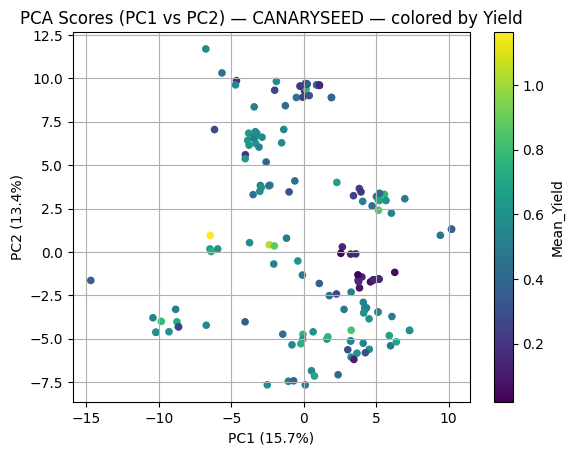

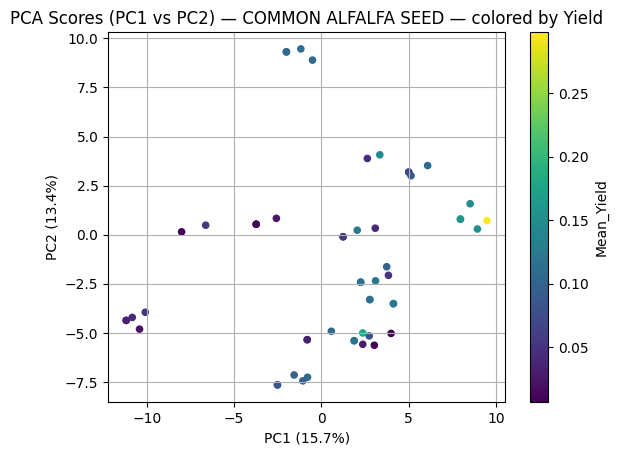

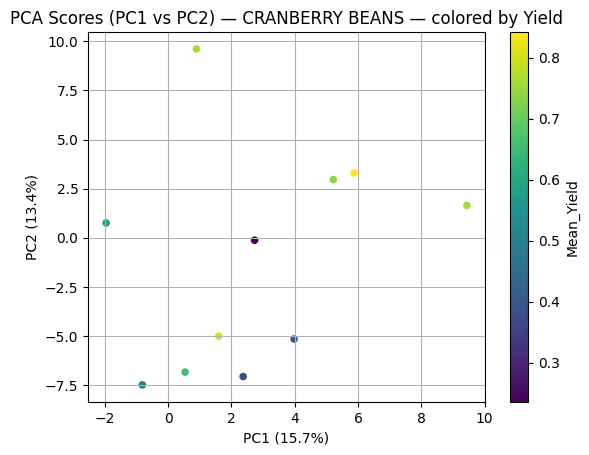

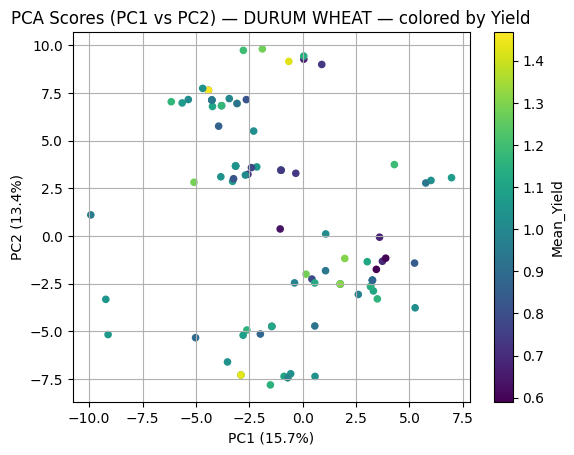

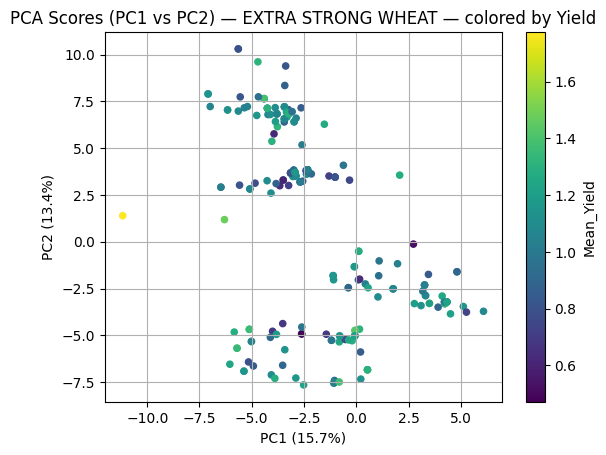

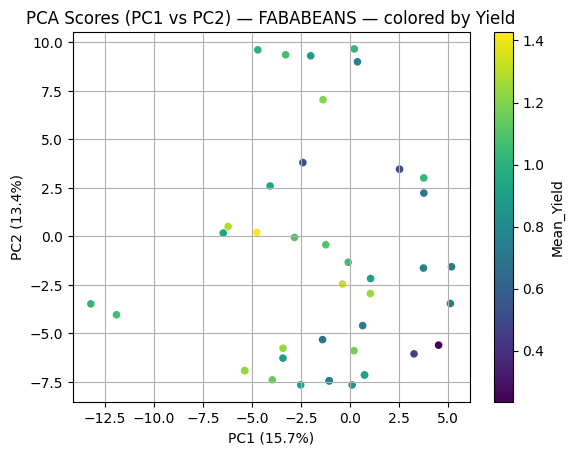

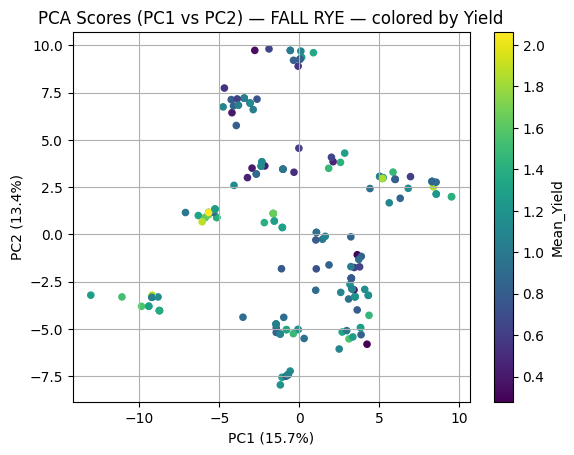

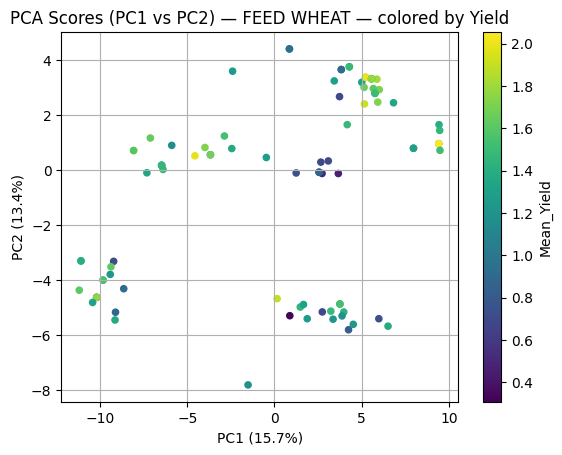

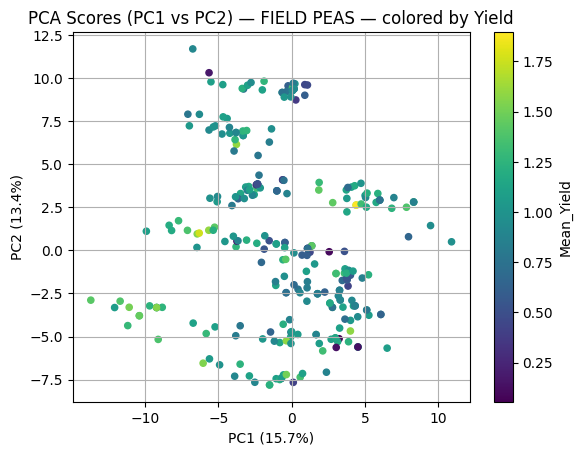

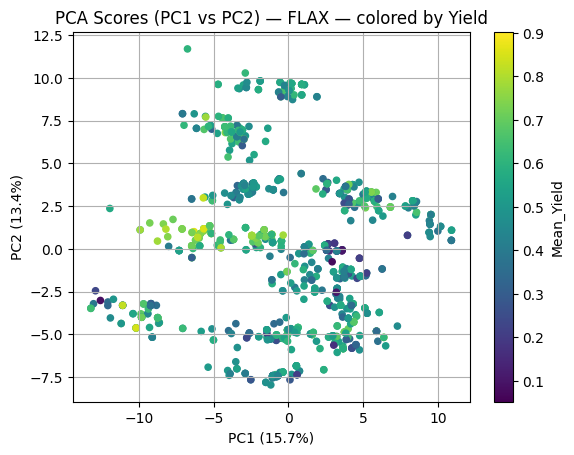

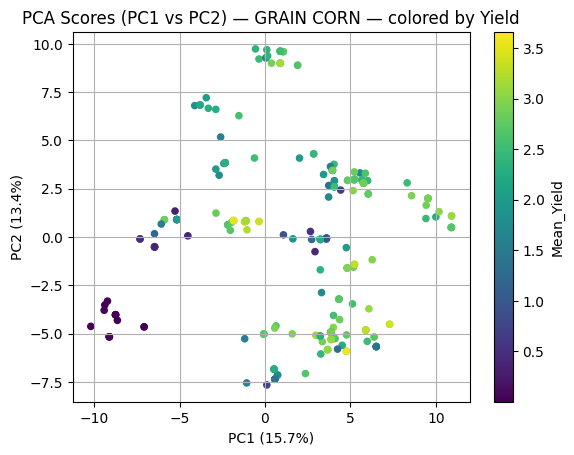

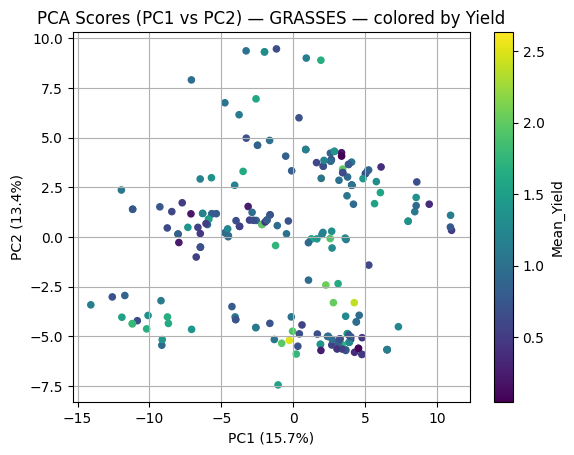

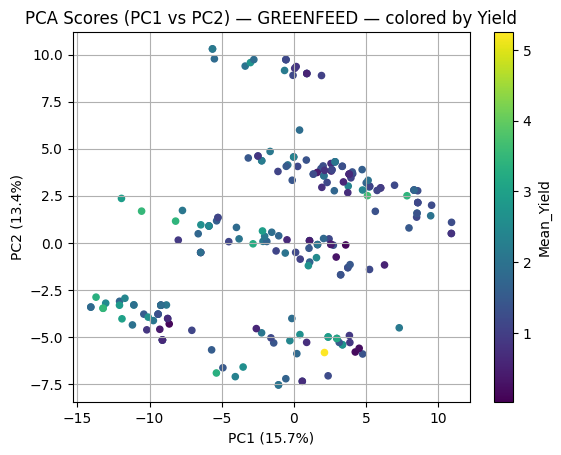

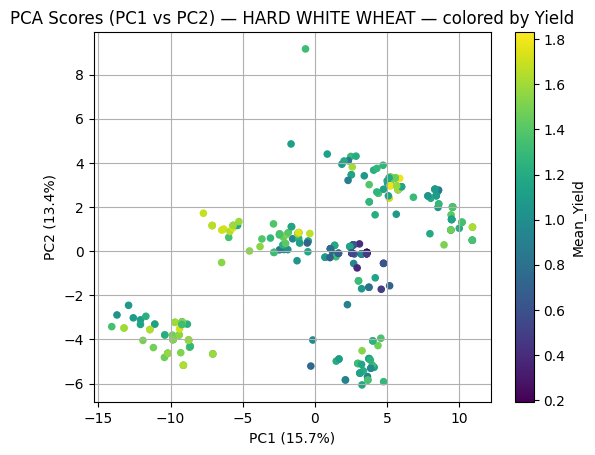

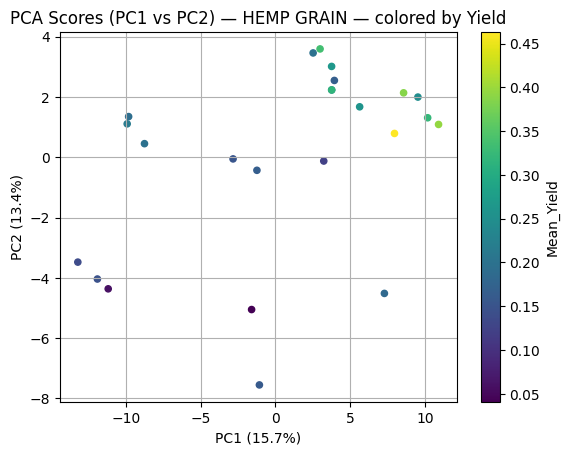

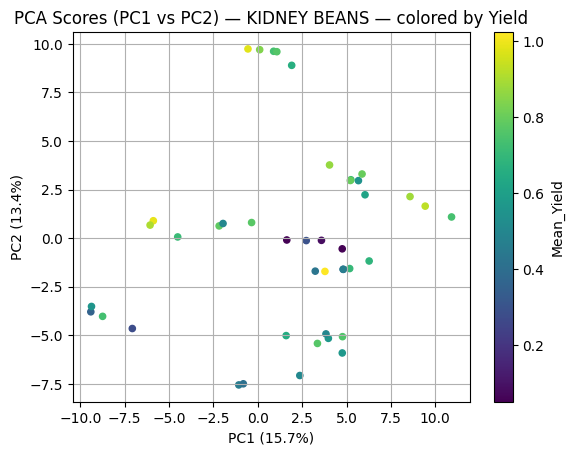

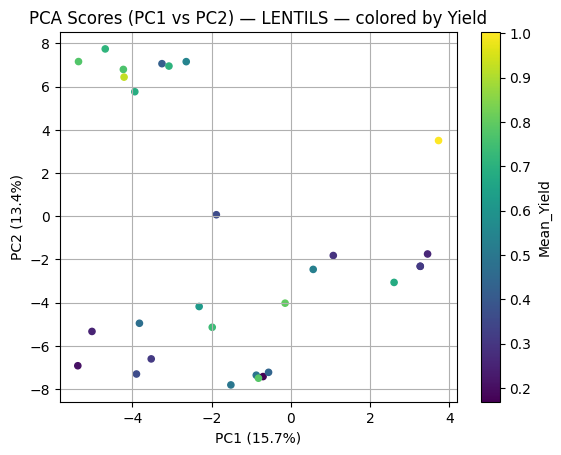

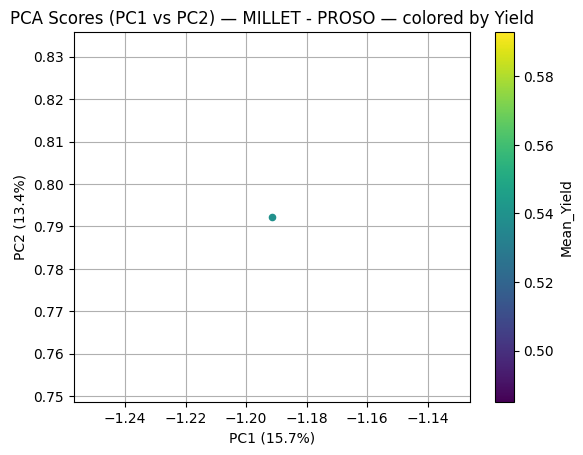

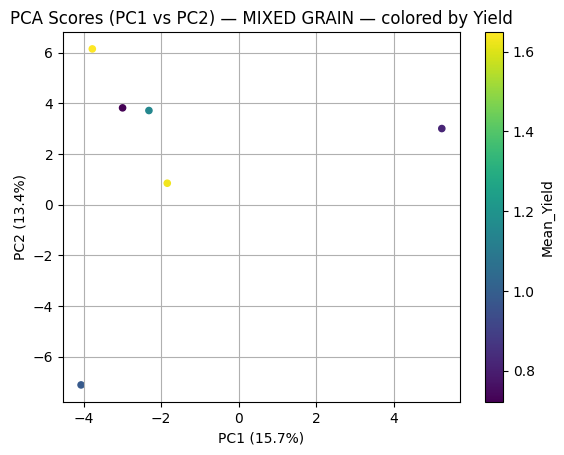

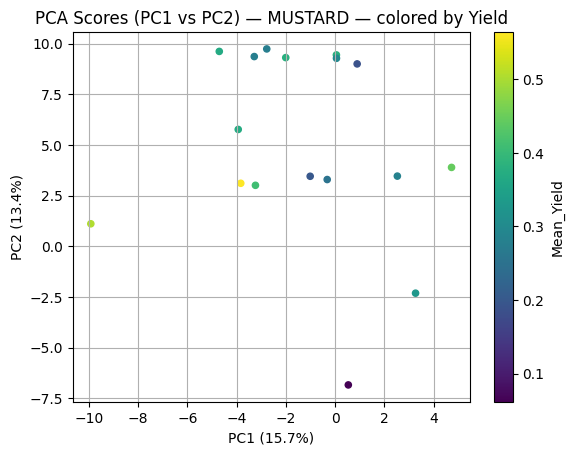

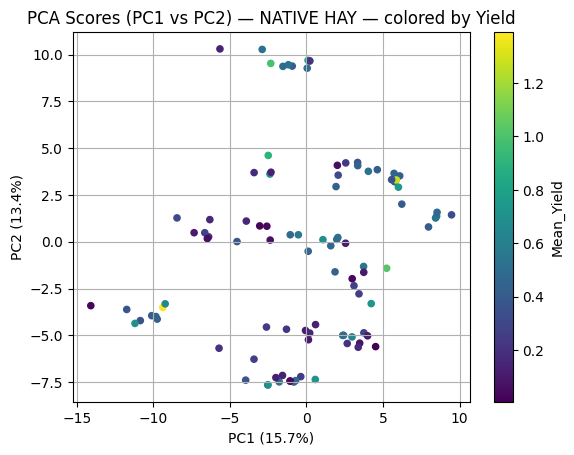

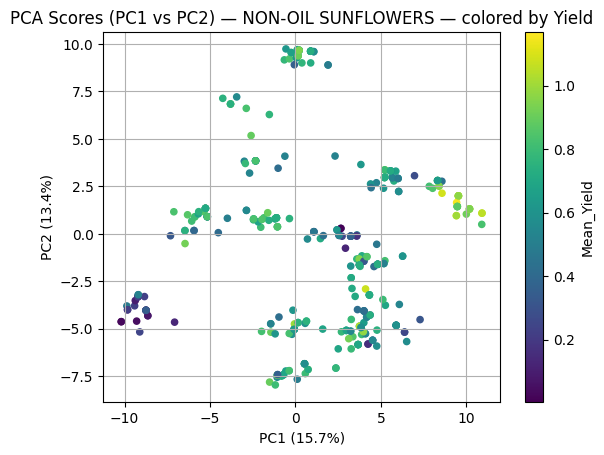

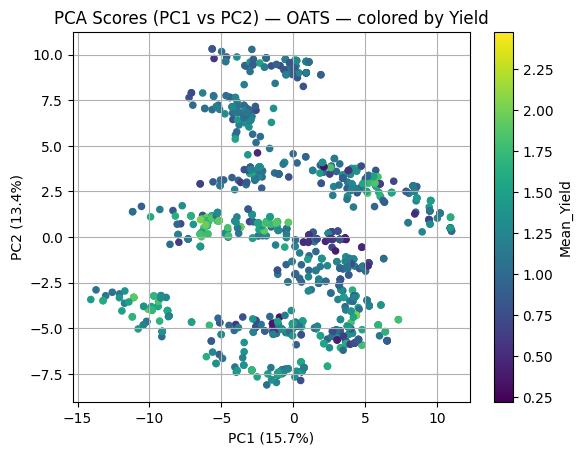

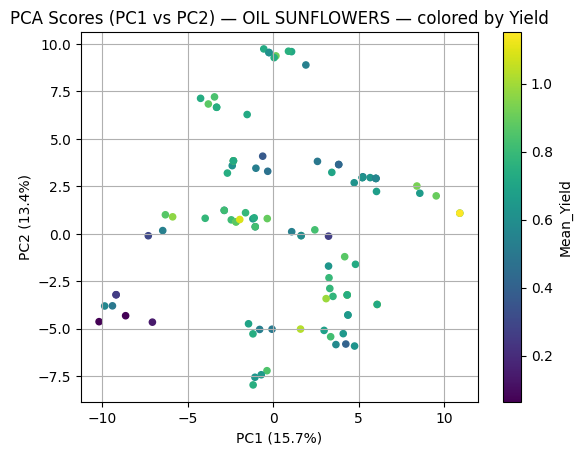

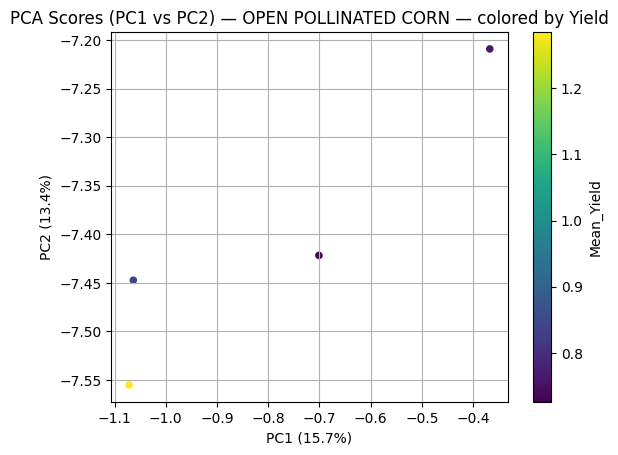

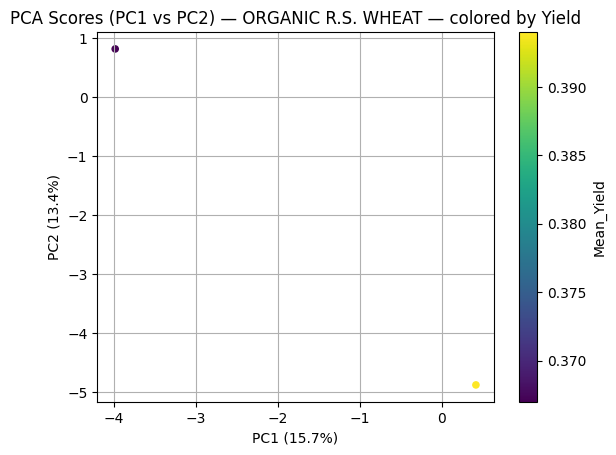

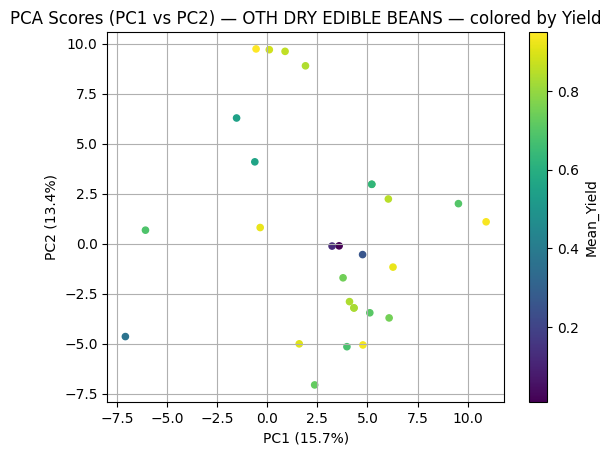

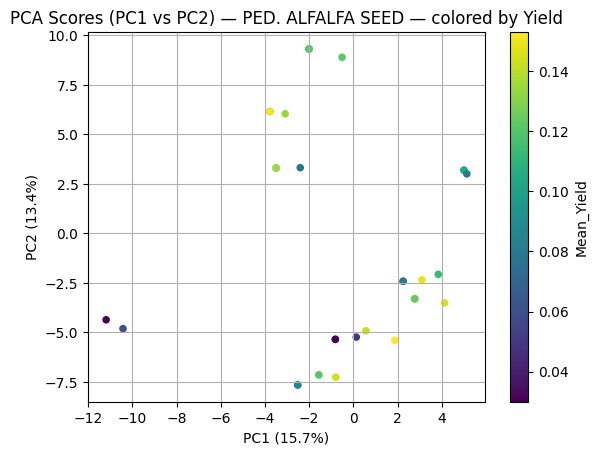

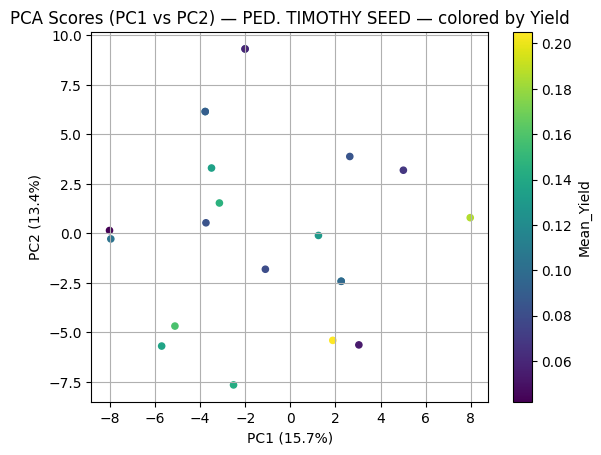

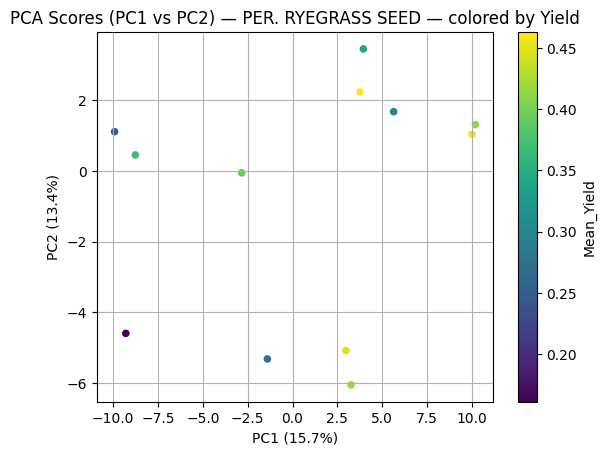

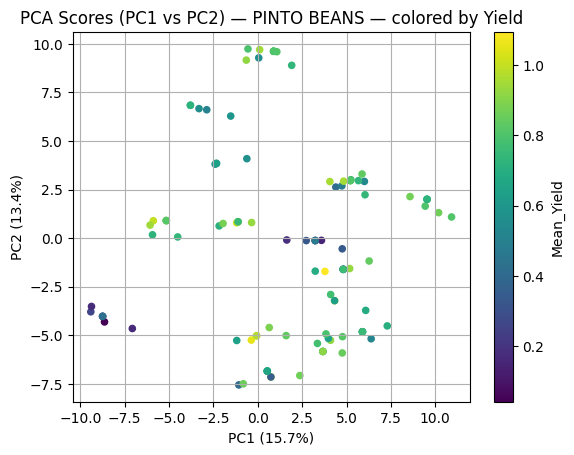

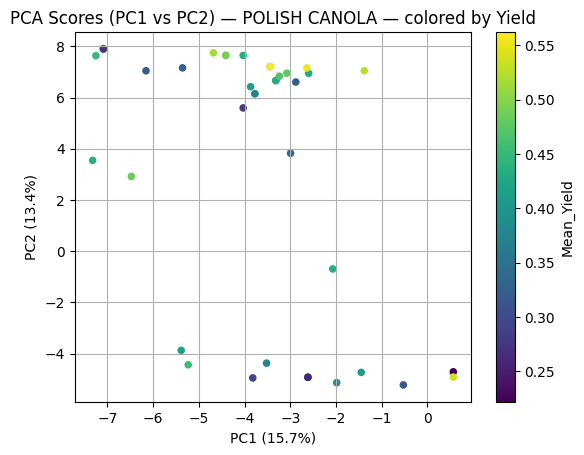

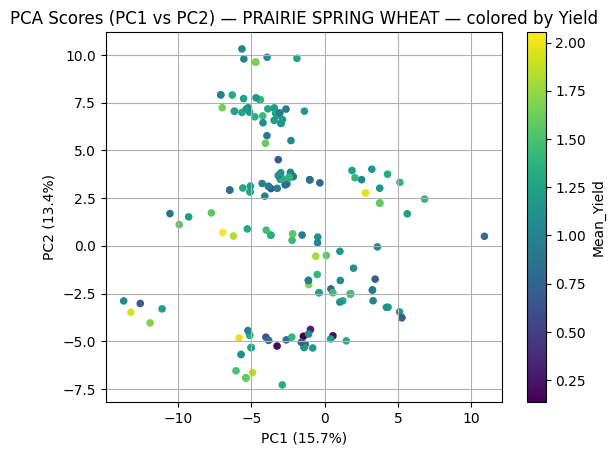

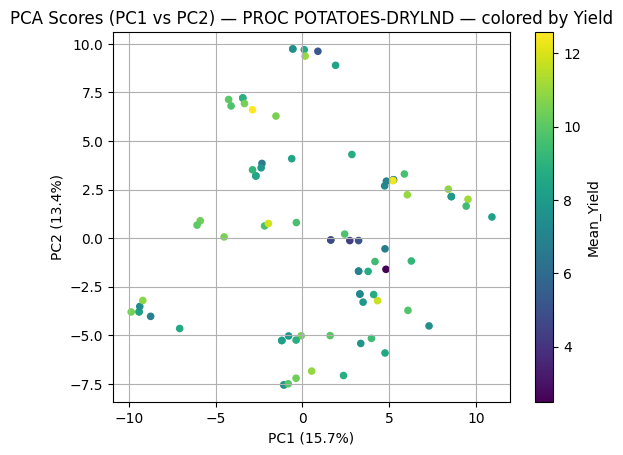

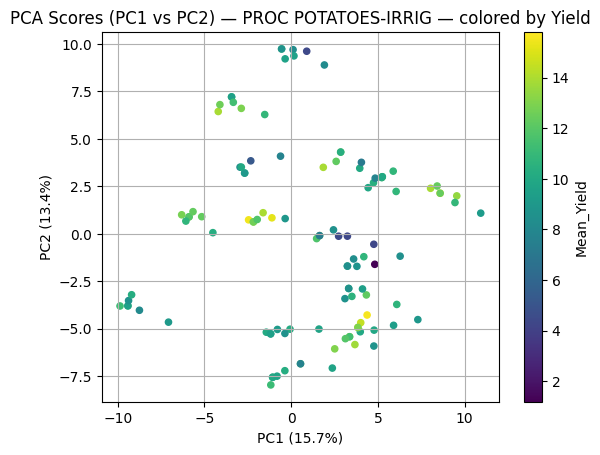

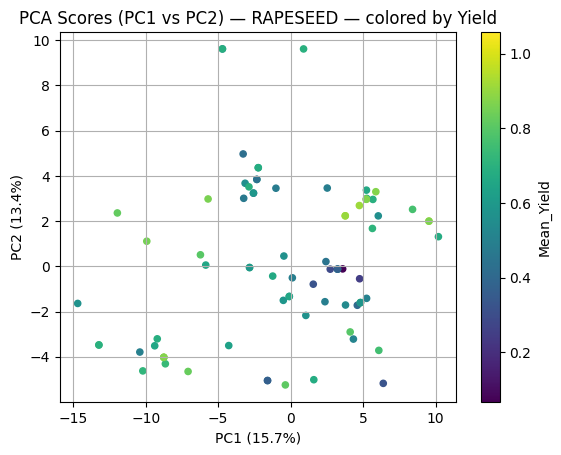

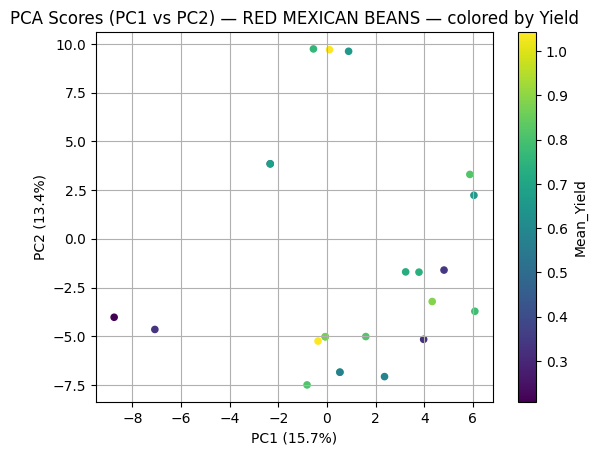

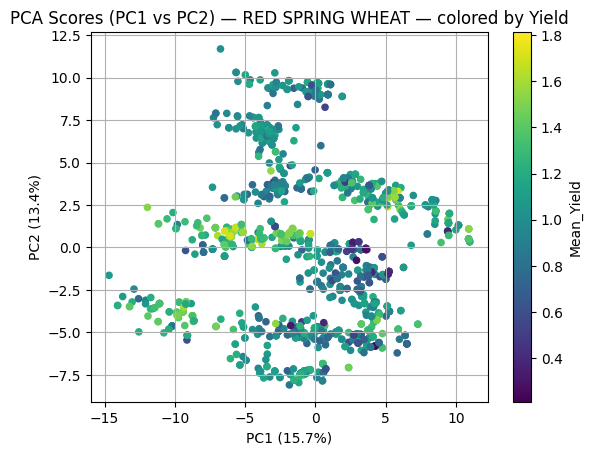

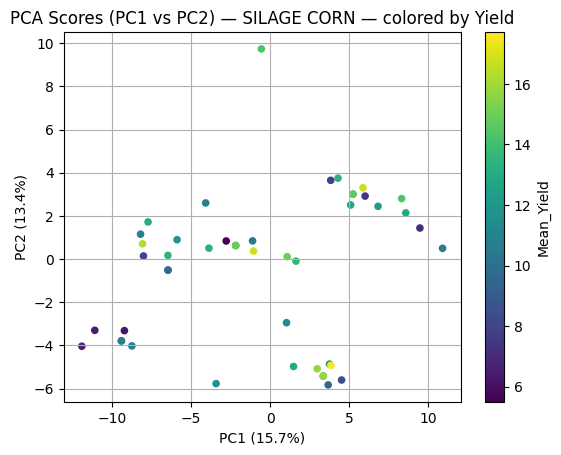

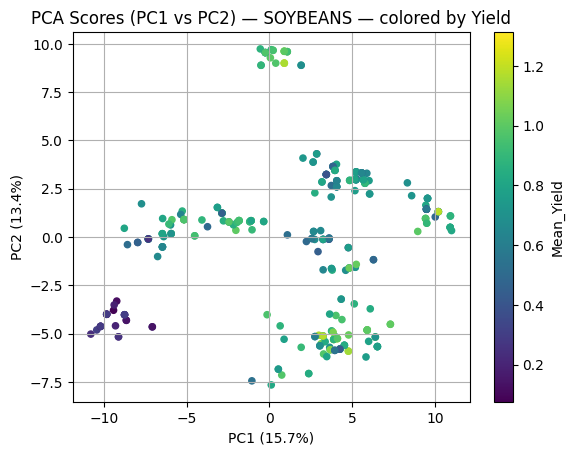

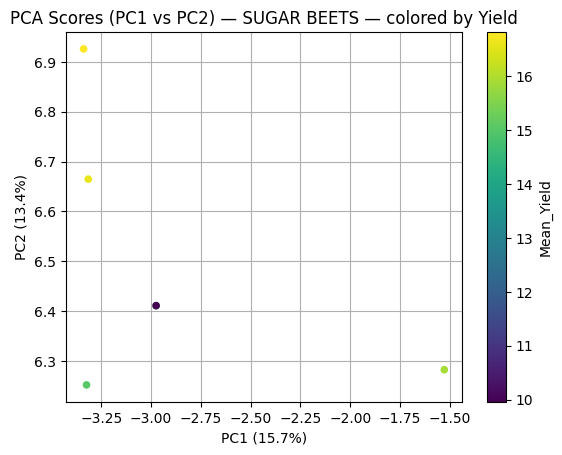

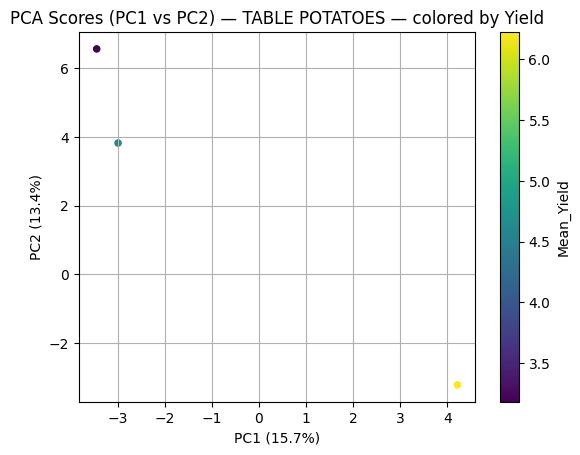

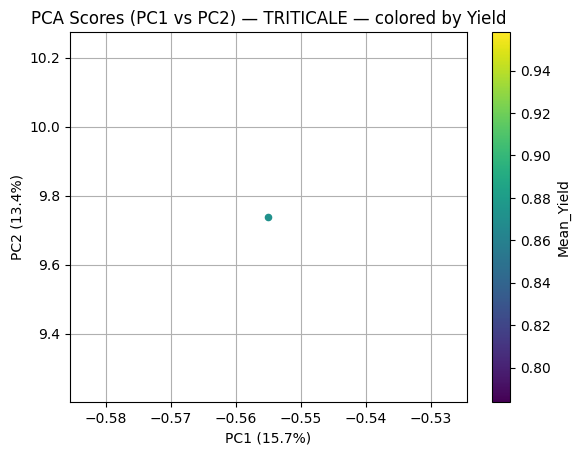

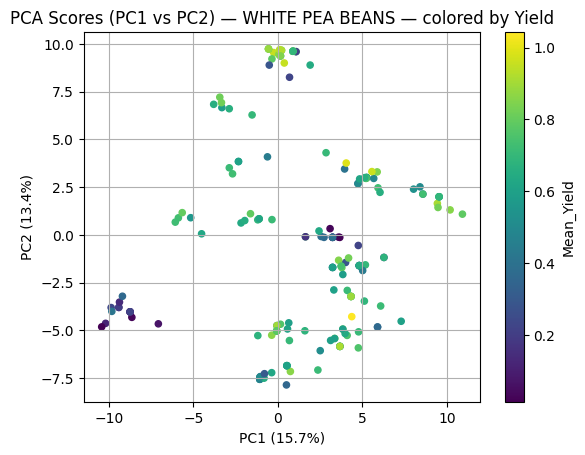

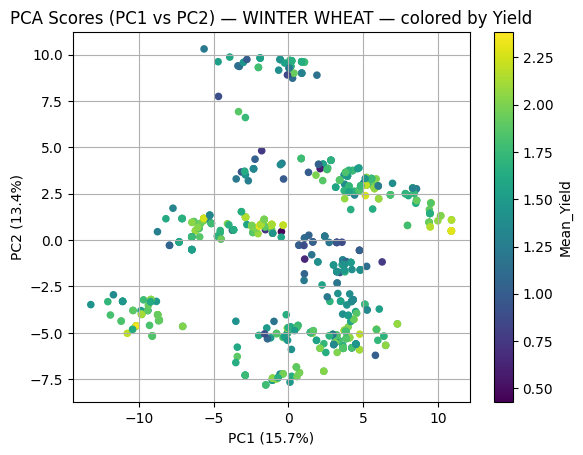

In [36]:
pcx, pcy = "PC1", "PC2"
yield_col = "Mean_Yield"
crop_col = "Crop"

plot_df = scores.dropna(subset=[pcx, pcy, yield_col]).copy()

for crop, g in plot_df.groupby(crop_col):
    plt.figure()
    sc = plt.scatter(g[pcx], g[pcy], s=20, c=g[yield_col])
    plt.xlabel(f"{pcx} ({expl.loc[0,'explained_variance_ratio']*100:.1f}%)")
    plt.ylabel(f"{pcy} ({expl.loc[1,'explained_variance_ratio']*100:.1f}%)")
    plt.title(f"PCA Scores (PC1 vs PC2) — {crop} — colored by Yield")
    plt.grid(True)
    cbar = plt.colorbar(sc)
    cbar.set_label(yield_col)
    plt.show()